# **I certify that the code and data in this assignment were generated on my own, using only the tools and resources given in the course and that I did not receive any external help, coaching or contributions during the production of this work.**

## Importing and creating file and method for plotting

In [ ]:
!pip install gym[box2d]==0.26.2
!pip install gym==0.26.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 721 kB 6.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 18.3 MB 125 kB/s 
     |████████████████████████████████| 2.1 MB 45.7 MB/s 
     |████████████████████████████████| 1.8 MB 46.3 MB/s 
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827650 sha256=17d296abb506f5e38b2820ae6c11e36ec1c651d284d4bb0dcdd8bbc26282c718
  Stored in directory: /root/.cache/pip/wheels/4d/c8/dc/d08577bffa680f083f04448e81e4f176d0e45a13eb16f93c0c
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import random
import torch.nn as nn
from torch import optim
import torch
import gym
from gym import spaces
import collections
import torch.nn.functional as F
from torchvision import transforms as T
import json
print(gym.__version__)
from google.colab import drive
assert gym.__version__ == "0.26.2"

0.26.2


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# with open("/content/drive/MyDrive/plot_file_for_dqn_dueldqn.json",'w') as f:
#     json.dump({'plot_dict':[]},f,indent=4)

In [ ]:
plot_dict = open("/content/drive/MyDrive/plot_file_for_dqn_dueldqn.json","r")
plot_dict=json.load(plot_dict)

In [ ]:
def plot_dict_save():
  with open("/content/drive/MyDrive/plot_file_for_dqn_dueldqn.json",'w') as f:
    json.dump(plot_dict,f,indent=4)

## Solving Grid using DQN and Duelling DQN

### Defining the grid world environment from assignment 1

In [ ]:
class environment(gym.Env):
  metadata = { 'render.modes': []} 
  def __init__(self):
    self.observation_space=spaces.Discrete(25)   #making a 5X5 grid
    self.action_space=spaces.Discrete(4)   #4 actions with 0 as right, 1 as left, 2 as down and 3 as up
    self.max_timesteps=15    #defining the minimum number of timesteps required
    self.reward1=[1,2]    #reward1 at a state, reward is 60
    self.penalty1=[2,4]   #penaty1 at a state, reward is -50
    self.penalty2=[0,4]   #penalty2 at a state, reward is -75
    self.agent=[0,0]      #initial position of agent
    self.start = [0,0]    #start of the env
    self.goal=[4,4]       #goal position of agent
    self.step_action=0
    self.done = False
    self.reward1_completed = False

  def step(self,action):
    probability_action = np.random.random()   #transitional probability of action
    reward = 0
    if action == 0 and probability_action<=0.75:
      self.agent[1]+=1
    elif action == 1 and probability_action<=0.8:
      self.agent[1]-=1
    elif action == 2 and probability_action<=0.85:
      self.agent[0]+=1
    elif action == 3 and probability_action<=0.79:
      self.agent[0]-=1
    self.agent = np.clip(self.agent,0,4)   #preventing the agent to go off grid
    probability_reward = np.random.random()   #transitional probability of reward
    if(self.agent == self.reward1).all() and probability_reward<=0.7:
      if not self.reward1_completed:
        reward = 1
        self.reward1_completed = True
    elif(self.agent == self.penalty1).all() and probability_reward<=0.72:
      reward = -50
    elif(self.agent == self.penalty2).all() and probability_reward<=0.73:
      reward = -50
    elif(self.agent == self.goal).all():
      reward = 240
    self.step_action += 1

    if (self.step_action>=self.max_timesteps) or (self.agent == self.goal).all():
      self.done = True
    else:
      self.done = False

    self.state = np.zeros((5,5))
    self.state[tuple(self.agent)] = 1
    self.state[tuple(self.goal)] = 0.75
    self.state[tuple(self.reward1)]=0.55
    self.state[tuple(self.penalty1)]=0.2
    self.state[tuple(self.penalty2)]=0.3
    obs = self.state.flatten()
    return self.agent,reward,self.done

  def reset(self):
    self.step_action=0
    self.done = False
    self.agent=[0,0]
    self.goal=[4,4]
    self.start=[0,0]
    self.state=np.zeros((5,5))
    self.state[tuple(self.agent)]=1
    self.state[tuple(self.goal)]=0.75
    self.state[tuple(self.reward1)]=0.55
    self.state[tuple(self.penalty1)]=0.2
    self.state[tuple(self.penalty2)]=0.3
    self.reward1_completed = False
    return self.agent

  def render(self):
    plt.imshow(self.state)

  #function to feed the input to the neural network
  def get_state(self):
    obs=np.zeros((4,5,5))
    obs[0][tuple(grid.agent)]=1
    if not self.reward1_completed:
        obs[1][tuple(grid.reward1)] = 1
    obs[2][tuple(grid.penalty1)] = 1
    obs[2][tuple(grid.penalty2)]= 1
    obs[3][tuple(grid.goal)] = 1
    return obs.flatten()

In [ ]:
e=environment()
e.reset()

[0, 0]

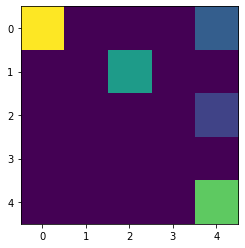

In [ ]:
e.render()

### Defining DQN Model

#### reference:
#### https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
#### https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html


##### Network architecture for DQN

In [ ]:
class model_dqn_grid(nn.Module):
    def __init__(self):
        super().__init__()
        self.fully_connect1 = nn.Linear(100,256)
        self.fully_connect2 = nn.Linear(256,128)
        self.output = nn.Linear(128,4)
    def forward(self,interface):
        interface = F.relu(self.fully_connect1(interface))
        interface = F.relu(self.fully_connect2(interface))
        interface = self.output(interface)
        return interface

##### Replay Buffer for further actions

In [ ]:
class Replay_Memory:
    def __init__(self,size_memory,size_for_sample):
        self.size_memory = size_memory
        self.size_for_sample = size_for_sample
        self.batch =collections.deque(maxlen=size_memory)
    def insert(self,x):
        self.batch.append(x)
    def batch_to_sample(self):
        return random.sample(self.batch,self.size_for_sample)

In [ ]:
def extract(instances):
  s,ns,r,a,d=list(),list(),list(),list(),list()
  for st,at,rt,nst,dt in instances:
    s.append(st)
    ns.append(nst)
    r.append(rt)
    a.append(at)
    d.append(dt)
  return torch.tensor(np.array(s),dtype=torch.float32),torch.tensor(a,dtype=torch.float32),torch.tensor(r,dtype=torch.float32),torch.tensor(np.array(ns),dtype=torch.float32),d

In [ ]:
class Agent:
    def __init__(self,actions,max_epsilon,min_epsilon,decay_rate):
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.actions = actions
        self.timest = 0  
    def select_action(self,s,p):
        self.timest += 1
        r = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-1 * self.timest * self.decay_rate)
        if r <= random.random():
          with torch.no_grad():
                return p(s).argmax().item(),r
        else:
          return random.randrange(self.actions),r

##### getting the predicted q value

In [ ]:
def get_predict(rewards,gamma,next_states,dones,target,actions,current_qs):
    values,output = list(),list()
    for r,nq,d in zip(rewards,target(next_states),dones):
        if not d:
            values.append(r + max(nq)*gamma)
        else:
            values.append(r)
    current_qs = current_qs.clone().detach().numpy()
    for cq,a,v in zip(current_qs,actions,values):
        cq[int(a)] = v
        output.append(cq)
    return torch.tensor(np.array(output))  

### Training the grid world environment using DQN neural network

In [ ]:
def training_dqn_grid(min_epsilon,max_epsilon,decay_rate,num_of_episodes,gamma,batch_size,grid):
    actions,updating_target_freq = 4,10
    agent = Agent(actions,max_epsilon,min_epsilon,decay_rate)
    policy_to_follow,target_value = model_dqn_grid(),model_dqn_grid()
    replay_buffer = Replay_Memory(10000,batch_size)
    target_value.load_state_dict(policy_to_follow.state_dict())
    target_value.eval()
    optimizer = optim.Adam(params=policy_to_follow.parameters(),lr=0.001)
    reward_episode,list_of_epsilon = list(),list()
    episode=0
    while episode<num_of_episodes:
        grid.reset()
        state = grid.get_state()
        reward_for_episode = 0
        while not grid.done:
            action,current_epsilon = agent.select_action(torch.tensor(state,dtype=torch.float32),target_value)
            a,reward,d = grid.step(action)
            list_of_epsilon.append(current_epsilon)
            reward_for_episode += reward
            next_state = grid.get_state()
            replay_buffer.insert([state,action,reward,next_state,grid.done])
            state = next_state
            if len(replay_buffer.batch) > replay_buffer.size_for_sample:
                buffer = replay_buffer.batch_to_sample()
                states, actions, rewards, next_states, completed = extract(buffer)
                current_qs = policy_to_follow(states)
                predict = get_predict(rewards,gamma,next_states,completed,target_value,actions,current_qs)
                loss = F.mse_loss(predict,current_qs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        if episode % updating_target_freq == 0:
            target_value.load_state_dict(policy_to_follow.state_dict())
        reward_episode.append(reward_for_episode)
        training_completion = int((episode/num_of_episodes)*100)
        print("Percentage of Training completed:",training_completion+1,"%")
        clear_output(wait=True)
        episode+=1
    #plotting reward per episode and epsilon decay
    aggeregate = np.cumsum(np.insert(reward_episode, 0, 0)) 
    mean_rew = (aggeregate[100:] - aggeregate[:-100]) / float(100)
    fig,pl=plt.subplots(2)
    plt.subplots_adjust(bottom=0.1,top=2)
    pl[0].plot(mean_rew)
    pl[0].set_title('Rewards per Episode')
    pl[0].set_xlabel('number of episodes')
    pl[0].set_ylabel('reward for episodes')
    pl[1].plot(list_of_epsilon)
    pl[1].set_title('Epsilon Decay')
    pl[1].set_xlabel('actions')
    pl[1].set_ylabel('Epsilon')
    #storing reward per episode, epsilon decay
    plot_dict['dqn_grid']=[mean_rew.tolist(),list_of_epsilon]
    plot_dict_save()
    return policy_to_follow

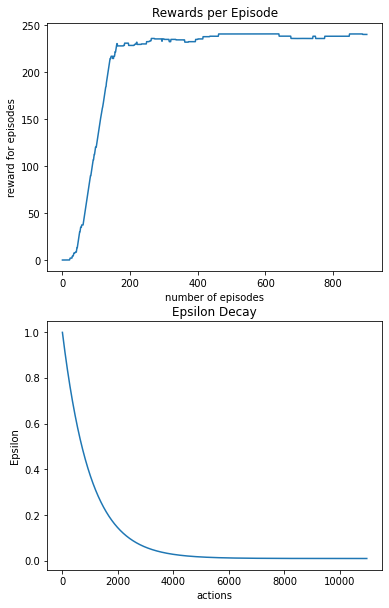

In [ ]:
grid = environment()
policy_to_follow = training_dqn_grid(0.01,1,0.001,1000,0.93,256,grid)   #min_epsilon,max_epsilon,decay_rate,num_of_episodes,gamma,batch_size,grid

### Testing the trained DQN network on grid world environment

In [ ]:
def testing_dqn_grid(no_evaluation_episodes,policy_to_follow,grid):
    list_of_reward,i = list(),0
    while(i<no_evaluation_episodes):
        grid.reset()
        state = torch.tensor(grid.get_state(),dtype=torch.float32)
        episodic_reward = 0
        d=False
        while not d:
            act = policy_to_follow(state).argmax().item()
            a,r,d = grid.step(act)
            episodic_reward += r
            state = torch.tensor(grid.get_state(),dtype=torch.float32)
        list_of_reward.append(episodic_reward)
        i+=1
    #plotting reward when agent follows greedy policy
    plt.plot(list_of_reward)
    plt.xlabel('episodes')
    plt.ylabel('reward for episodes')
    plt.title("Evaluation for the learnt policy")
    plot_dict['dqn_test_grid']=list_of_reward
    plot_dict_save()

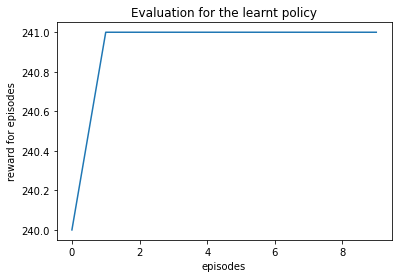

In [ ]:
grid = environment()
testing_dqn_grid(10,policy_to_follow,grid)

### Solving Grid environment using Duelling DQN

#### Network architecture for Duelling DQN

In [ ]:
class model_duelling_dqn_grid(nn.Module):
  def __init__(self):
    super().__init__()
    self.fully_connected1=nn.Linear(100,256)
    self.fully_connected2=nn.Linear(256,128)
    self.validation_layer1=nn.Linear(128,64)
    self.advantage_layer1=nn.Linear(128,64)
    self.validation_layer2=nn.Linear(64,1)
    self.advantage_layer2=nn.Linear(64,4)
  def forward(self,a):
    a=F.relu(self.fully_connected1(a))
    a=F.relu(self.fully_connected2(a))
    b=F.relu(self.advantage_layer1(a))
    b=self.advantage_layer2(b)
    c=F.relu(self.validation_layer1(a))
    c=self.validation_layer2(c)
    return c+b-b.mean()

### Training the grid world environment using Duelling DQN neural network

In [ ]:
def training_duel_dqn_grid(min_epsilon,max_epsilon,decay_rate,num_of_episodes,gamma,batch_size,grid):
    actions,updating_target_freq = 4,10
    agent = Agent(actions,max_epsilon,min_epsilon,decay_rate)
    policy_to_follow,target_value = model_duelling_dqn_grid(),model_duelling_dqn_grid()
    replay_buffer = Replay_Memory(10000,batch_size)
    target_value.load_state_dict(policy_to_follow.state_dict())
    target_value.eval()
    optimizer = optim.Adam(params=policy_to_follow.parameters(),lr=0.001)
    reward_episode,list_of_epsilon = list(),list()
    episode=0
    while episode<num_of_episodes:
        grid.reset()
        state = grid.get_state()
        reward_for_episode = 0
        while not grid.done:
            action,current_epsilon = agent.select_action(torch.tensor(state,dtype=torch.float32),target_value)
            a,reward,d = grid.step(action)
            list_of_epsilon.append(current_epsilon)
            reward_for_episode += reward
            next_state = grid.get_state()
            replay_buffer.insert([state,action,reward,next_state,grid.done])
            state = next_state
            if len(replay_buffer.batch) > replay_buffer.size_for_sample:
                buffer = replay_buffer.batch_to_sample()
                states, actions, rewards, next_states, completed = extract(buffer)
                current_qs = policy_to_follow(states)
                predict = get_predict(rewards,gamma,next_states,completed,target_value,actions,current_qs)
                loss = F.mse_loss(predict,current_qs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        if episode % updating_target_freq == 0:
            target_value.load_state_dict(policy_to_follow.state_dict())
        reward_episode.append(reward_for_episode)
        training_completion = int((episode/num_of_episodes)*100)
        print("Percentage of Training completed:",training_completion+1,"%")
        clear_output(wait=True)
        episode+=1
    #plotting reward per episode and epsilon decay
    aggeregate = np.cumsum(np.insert(reward_episode, 0, 0)) 
    mean_rew = (aggeregate[100:] - aggeregate[:-100]) / float(100)
    fig,pl=plt.subplots(2)
    plt.subplots_adjust(bottom=0.1,top=2)
    pl[0].plot(mean_rew)
    pl[0].set_title('Rewards per Episode')
    pl[0].set_xlabel('number of episodes')
    pl[0].set_ylabel('reward for episodes')
    pl[1].plot(list_of_epsilon)
    pl[1].set_title('Epsilon Decay')
    pl[1].set_xlabel('actions')
    pl[1].set_ylabel('Epsilon')
    #storing reward per episode, epsilon decay
    plot_dict['duel_dqn_grid']=[mean_rew.tolist(),list_of_epsilon]
    plot_dict_save()
    return policy_to_follow

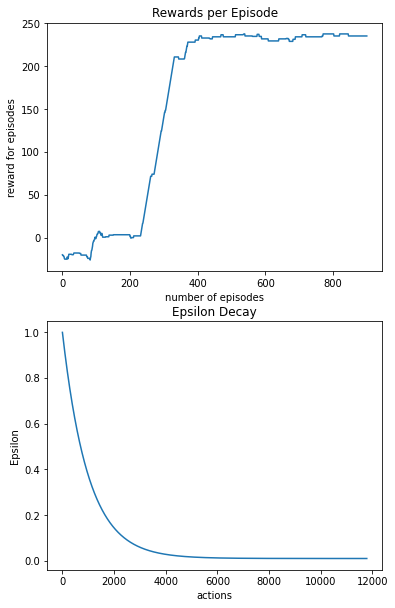

In [ ]:
grid = environment()
policy_to_follow = training_duel_dqn_grid(0.01,1,0.001,1000,0.99,256,grid)   #min_epsilon,max_epsilon,decay_rate,num_of_episodes,gamma,batch_size,grid

### Testing the trained Duelling DQN network on grid world environment

In [ ]:
def testing_duelling_dqn_grid(no_evaluation_episodes,policy_to_follow,grid):
    list_of_reward,i = list(),0
    while(i<no_evaluation_episodes):
        grid.reset()
        state = torch.tensor(grid.get_state(),dtype=torch.float32)
        episodic_reward = 0
        d=False
        while not d:
            act = policy_to_follow(state).argmax().item()
            a,r,d = grid.step(act)
            episodic_reward += r
            state = torch.tensor(grid.get_state(),dtype=torch.float32)
        list_of_reward.append(episodic_reward)
        i+=1
    #plotting reward when agent follows greedy policy
    plt.plot(list_of_reward)
    plt.xlabel('episodes')
    plt.ylabel('reward for episodes')
    plt.title("Evaluation for the learnt policy")
    plot_dict['duel_dqn_test_grid']=list_of_reward
    plot_dict_save()

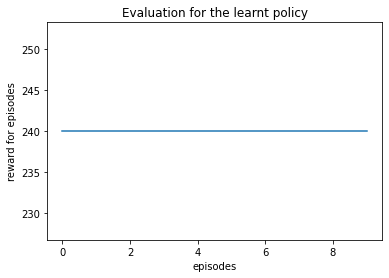

In [ ]:
grid = environment()
testing_duelling_dqn_grid(10,policy_to_follow,grid)

## Solving OpenAI gym environments using DQN and Duelling DQN

### Network Architectures

#### Defining the DQN Model


In [ ]:
class model_dqn(nn.Module):
    def __init__(self, actions, observation_space, neurons):
        super().__init__()
        self.fully_connect1 = nn.Linear(observation_space, neurons[0])
        self.fully_connect2 = nn.Linear(neurons[0], neurons[1])
        self.output = nn.Linear(neurons[1], actions)
    
    def forward(self,interface):
        interface = F.relu(self.fully_connect1(interface))
        interface = F.relu(self.fully_connect2(interface))
        interface = self.output(interface)
        return interface

#### Defining the Duelling DQN Model

In [ ]:
class model_duelling_dqn(nn.Module):
  def __init__(self, actions, observation_space, neurons):
    super().__init__()
    self.fully_connected1=nn.Linear(observation_space, neurons[0])
    self.fully_connected2=nn.Linear(neurons[0], neurons[1])
    self.validation_layer1=nn.Linear(neurons[1], neurons[2])
    self.advantage_layer1=nn.Linear(neurons[1], neurons[2])
    self.validation_layer2=nn.Linear(neurons[2], 1)
    self.advantage_layer2=nn.Linear(neurons[2], actions)

  def forward(self,a):
    a=F.relu(self.fully_connected1(a))
    a=F.relu(self.fully_connected2(a))
    b=F.relu(self.advantage_layer1(a))
    b=self.advantage_layer2(b)
    c=F.relu(self.validation_layer1(a))
    c=self.validation_layer2(c)
    return c+b-b.mean()

#### Replay Memory, Agent and helper funtions

In [ ]:
class Replay_Memory:
    def __init__(self,size_memory,size_for_sample):
        self.size_memory = size_memory
        self.size_for_sample = size_for_sample
        self.batch =collections.deque(maxlen=size_memory)
    def insert(self,x):
        self.batch.append(x)
    def batch_to_sample(self):
        return random.sample(self.batch,self.size_for_sample)

In [ ]:
class Agent:
    def __init__(self, actions, min_epsilon, max_epsilon, decay_rate, max_episodes):
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.max_episodes = max_episodes
        self.decay_rate = decay_rate
        self.actions = actions
        self.timest = 0 
        
    # episodes decide the epsilon rate
    def get_epsilon(self, episode):
        return self.min_epsilon ** (episode / self.max_episodes)
    
    def select_action(self, s, p, epsilon):
        self.timest += 1

        if random.random() <= epsilon:
            return random.randrange(self.actions - 1)
        else:
            with torch.no_grad():
                return p(s).argmax().item()

In [ ]:
def extract(instances):
  s,ns,r,a,d=list(),list(),list(),list(),list()
  for st,at,rt,nst,dt in instances:
    s.append(st)
    ns.append(nst)
    r.append(rt)
    a.append(at)
    d.append(dt)
  return torch.tensor(np.array(s),dtype=torch.float32),torch.tensor(a,dtype=torch.float32),torch.tensor(r,dtype=torch.float32),torch.tensor(np.array(ns),dtype=torch.float32),d

def get_predict(rewards,gamma,next_states,dones,target,actions,current_qs):
    values,output = list(),list()
    for r,nq,d in zip(rewards,target(next_states),dones):
        if not d:
            values.append(r + max(nq)*gamma)
        else:
            values.append(r)
    current_qs = current_qs.clone().detach().numpy()
    for cq,a,v in zip(current_qs,actions,values):
        cq[int(a)] = v
        output.append(cq)
    return torch.tensor(np.array(output))  

### Train & Test Methods For OpenAI gym environments

In [ ]:
def training_gym_env(action_space, obs_space, min_epsilon,max_epsilon,decay_rate,num_of_episodes,gamma,batch_size, env,use_duelling = False,learning_r=0.001,replay_buffer_size=10000, neurons = None):
  updating_target_freq = 10
  agent = Agent(action_space, min_epsilon, max_epsilon, decay_rate, num_of_episodes)
  
  if use_duelling:
    if neurons is None:
      neurons=[256, 128, 64]
    policy_to_follow, target_value = model_duelling_dqn(action_space, obs_space, neurons), model_duelling_dqn(action_space, obs_space, neurons)
  else:
    if neurons is None:
      neurons=[256, 128]
    policy_to_follow, target_value = model_dqn(action_space, obs_space, neurons), model_dqn(action_space, obs_space, neurons)
  replay_buffer = Replay_Memory(replay_buffer_size,batch_size)
  target_value.load_state_dict(policy_to_follow.state_dict())
  target_value.eval()
  optimizer = optim.Adam(params=policy_to_follow.parameters(),lr=learning_r)
  reward_episode, list_of_epsilon = list(), list()
  episode=0

  while episode<num_of_episodes:
      state, info = env.reset()
      reward_for_episode = 0
      done = False
      current_epsilon = agent.get_epsilon(episode)
      list_of_epsilon.append(current_epsilon)
      while not done:
          action = agent.select_action(torch.tensor(state, dtype=torch.float32), target_value, current_epsilon)
          next_state, reward, terminated, truncated, info = env.step(action)
          done = terminated or truncated
          reward_for_episode += reward
          replay_buffer.insert([state, action, reward, next_state, (terminated or truncated)])
          state = next_state
          if len(replay_buffer.batch) > replay_buffer.size_for_sample:
              buffer = replay_buffer.batch_to_sample()
              states, actions, rewards, next_states, completed = extract(buffer)
              current_qs = policy_to_follow(states)
              predict = get_predict(rewards, gamma, next_states, completed, target_value, actions, current_qs)
              loss = F.mse_loss(predict, current_qs)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
      if episode % updating_target_freq == 0:
          target_value.load_state_dict(policy_to_follow.state_dict())
      reward_episode.append(reward_for_episode)
      training_completion = int((episode/num_of_episodes)*100)
      print(f"Epsilon: {current_epsilon}, Training completed: {training_completion+1}%, Episode: {episode}")
      clear_output(wait=True)
      episode+=1
  #plotting reward per episode and epsilon decay
  fig,pl=plt.subplots(3)
  plt.subplots_adjust(bottom=0.1,top=4)

  pl[0].plot(reward_episode)
  pl[0].set_title('Rewards per Episode')
  pl[0].set_xlabel('number of episodes')
  pl[0].set_ylabel('reward for episodes')

  aggeregate = np.cumsum(np.insert(reward_episode, 0, 0)) 
  mean_rew = (aggeregate[100:] - aggeregate[:-100]) / float(100)
  pl[1].plot(mean_rew)
  pl[1].set_title('Mean Rewards per Episode')
  pl[1].set_xlabel('number of episodes')
  pl[1].set_ylabel('reward for episodes')

  pl[2].plot(list_of_epsilon)
  pl[2].set_title('Epsilon Decay')
  pl[2].set_xlabel('Episodes')
  pl[2].set_ylabel('Epsilon')

  name_of_env=env.spec.id
  if use_duelling:
    plot_dict["duel_dqn_"+name_of_env] = [mean_rew.tolist(),list_of_epsilon]
  else:
    plot_dict['dqn_'+name_of_env]=[mean_rew.tolist(),list_of_epsilon]
  plot_dict_save()
  return policy_to_follow

In [ ]:
def testing_gym_env(no_evaluation_episodes,policy_to_follow,env, use_duelling = False):
    list_of_reward,i = list(),0
    while(i<no_evaluation_episodes):
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        episodic_reward = 0
        done = False
        while not done:
            act = policy_to_follow(state).argmax().item()
            next_state, reward, terminated, truncated, info = env.step(act)
            done = terminated or truncated
            episodic_reward += reward
            state = torch.tensor(next_state,dtype=torch.float32)
        list_of_reward.append(episodic_reward)
        i+=1
    #plotting reward when agent follows greedy policy
    plt.plot(list_of_reward)
    plt.xlabel('episodes')
    plt.ylabel('reward for episodes')
    plt.title("Evaluation for the learnt policy")
    name_of_env = env.spec.id
    if use_duelling:
      plot_dict["duel_dqn_test_"+name_of_env] = list_of_reward
    else:
      plot_dict['dqn_test_'+name_of_env]= list_of_reward
    plot_dict_save()

### Solving the Cartpole Environment

In [ ]:
cartpole_env = gym.make("CartPole-v1")

 #### Using DQN

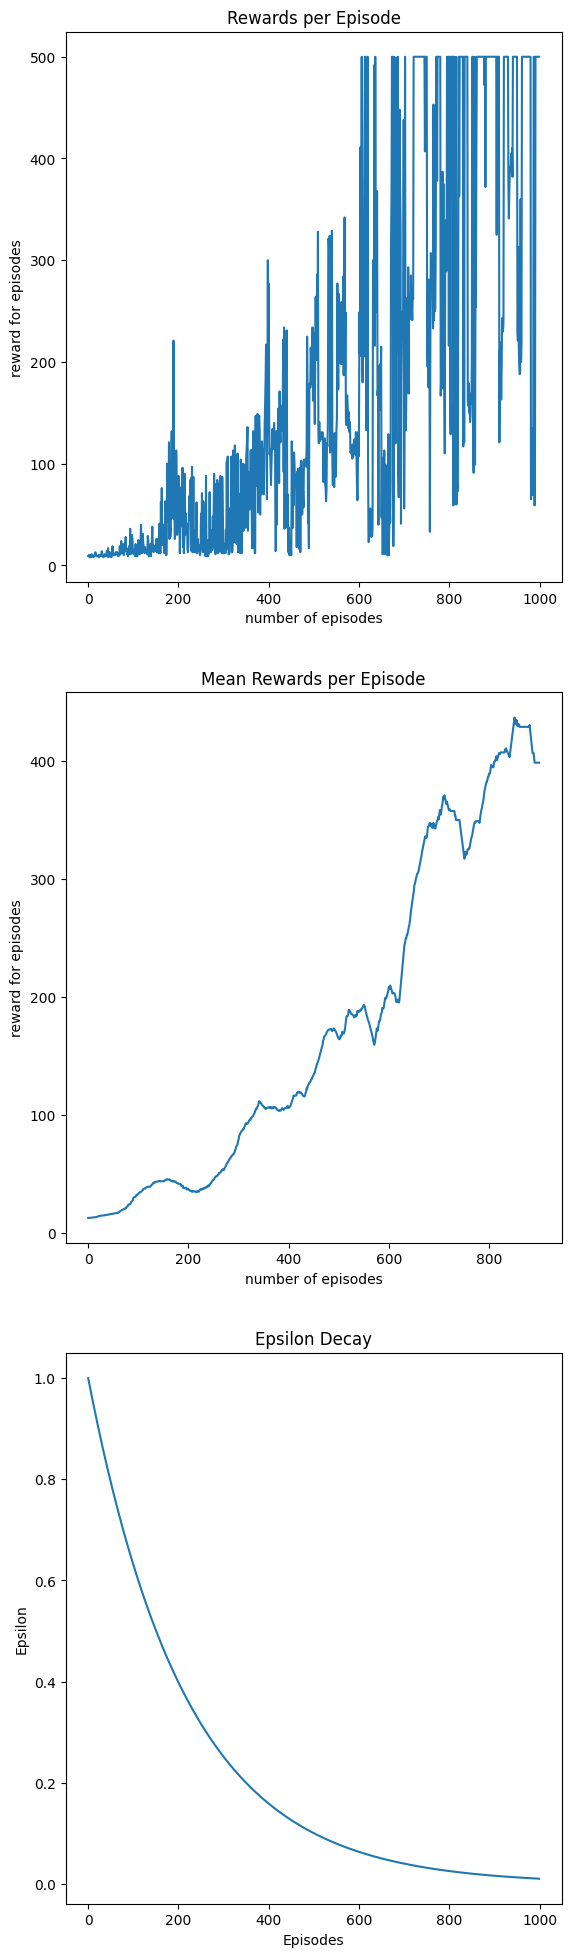

In [ ]:
policy_to_follow = training_gym_env(action_space=2,
                                        obs_space=4,
                                        min_epsilon=0.01,
                                        max_epsilon=1,
                                        decay_rate=0.001,
                                        num_of_episodes=1000,
                                        gamma=1,
                                        batch_size=256,
                                        env=cartpole_env)
cartpole_env.close()

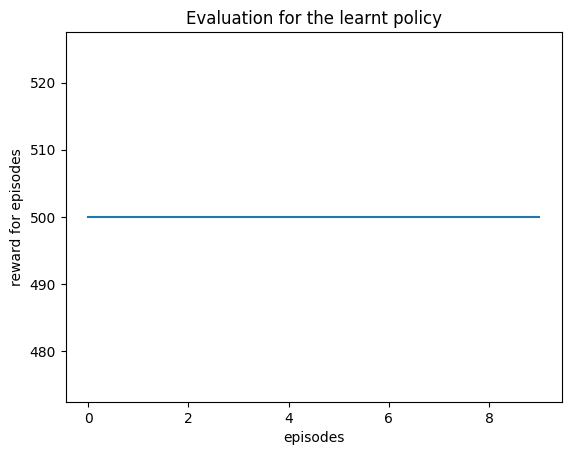

In [ ]:
testing_gym_env(no_evaluation_episodes=10, 
                    policy_to_follow=policy_to_follow, 
                    env=cartpole_env)
cartpole_env.close()

#### Using Duelling DQN

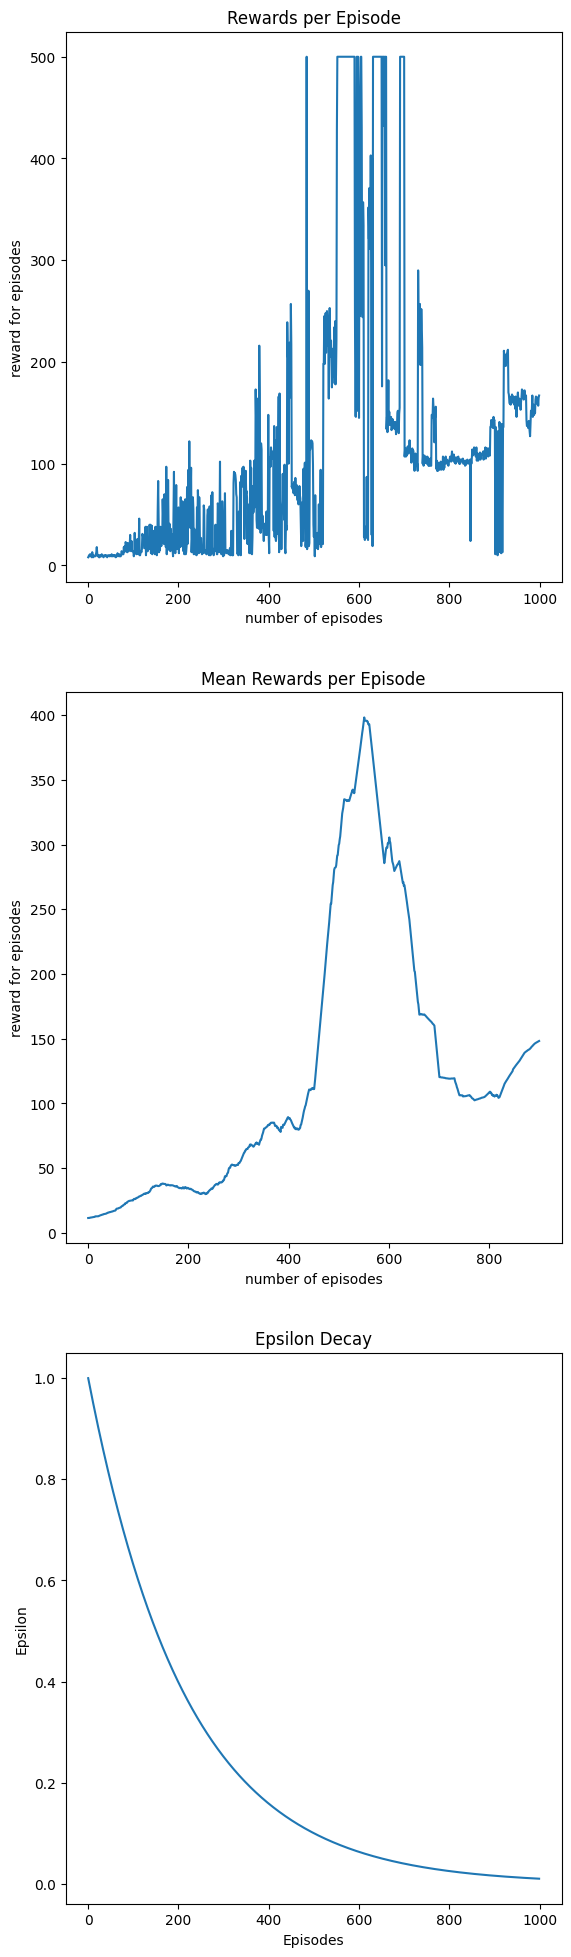

In [ ]:
policy_to_follow = training_gym_env(action_space=2,
                                        obs_space=4,
                                        min_epsilon=0.01,
                                        max_epsilon=1,
                                        decay_rate=0.001,
                                        num_of_episodes=1000,
                                        gamma=1,
                                        batch_size=128,
                                        use_duelling=True,
                                        learning_r = 0.001,
                                        neurons = [256, 64, 32],
                                        env=cartpole_env)
cartpole_env.close()

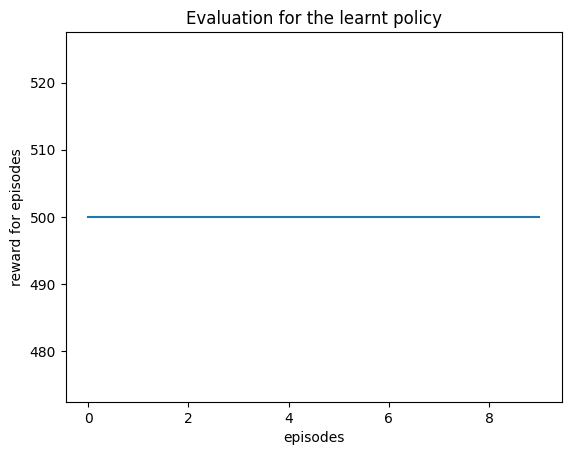

In [ ]:
testing_gym_env(no_evaluation_episodes=10, 
                    policy_to_follow=policy_to_follow, 
                    use_duelling=True,
                    env=cartpole_env)
cartpole_env.close()

### Solving for Acrobot Environment

In [ ]:
acrobot_env = gym.make('Acrobot-v1')

#### Using DQN

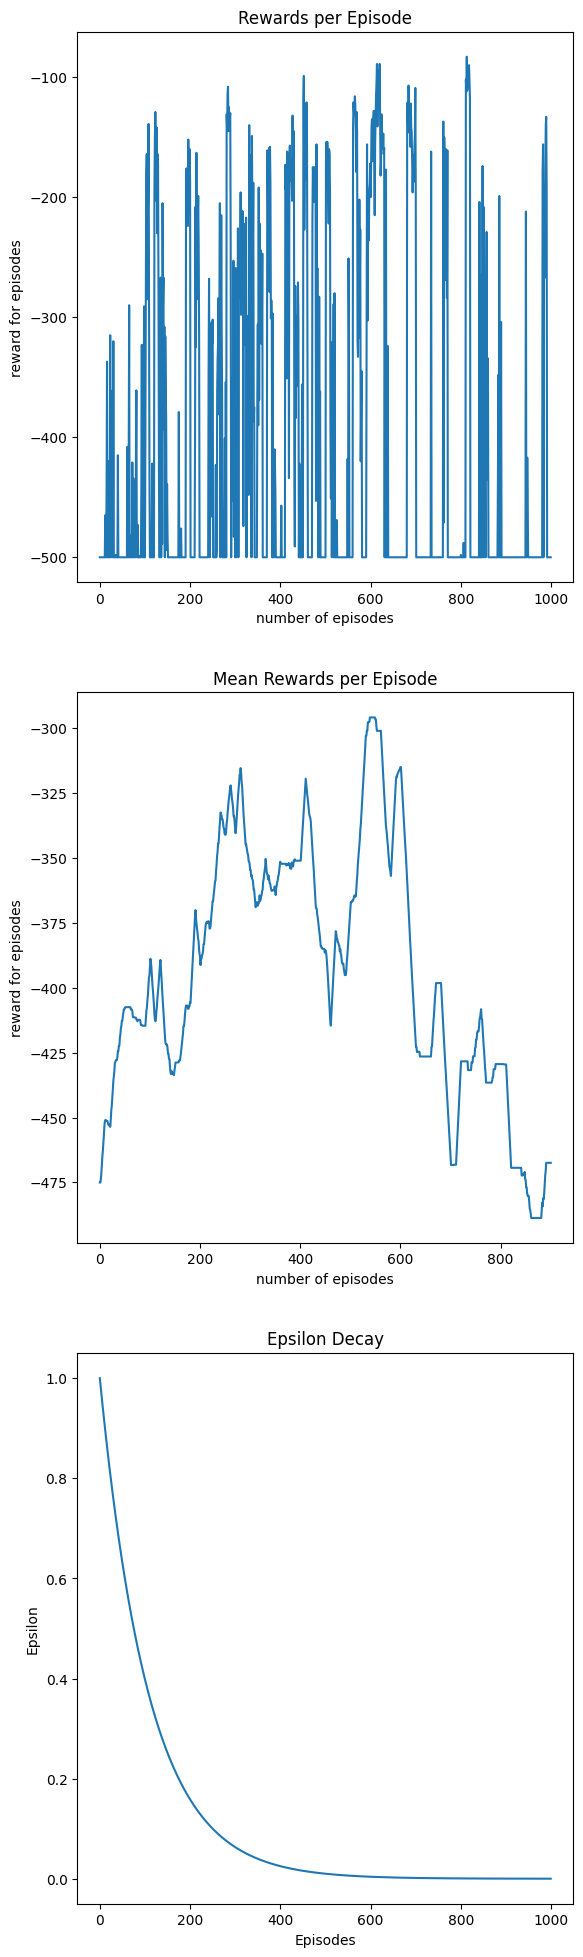

In [ ]:
policy_to_follow = training_gym_env(action_space=3,
                                        obs_space=6,
                                        min_epsilon=0.0001,
                                        max_epsilon=1,
                                        decay_rate=0.001,
                                        num_of_episodes=1000,
                                        gamma=0.93,
                                        batch_size=256,
                                        env=acrobot_env,
                                        replay_buffer_size=1000000,
                                        neurons=[256, 512],
                                        learning_r = 0.0001)
acrobot_env.close()

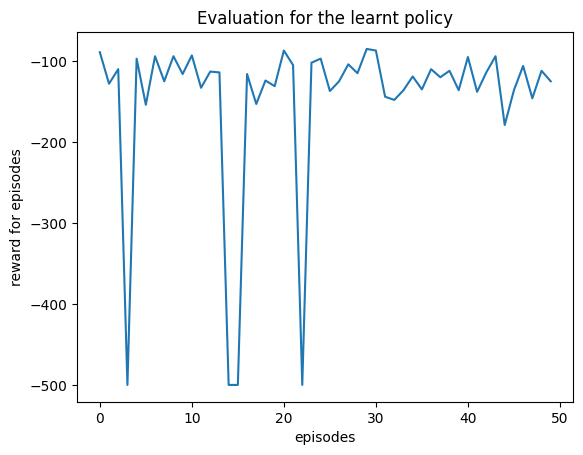

In [ ]:
testing_gym_env(no_evaluation_episodes=50, 
                    policy_to_follow=policy_to_follow, 
                    env=acrobot_env)
acrobot_env.close()

#### Using Duelling DQN

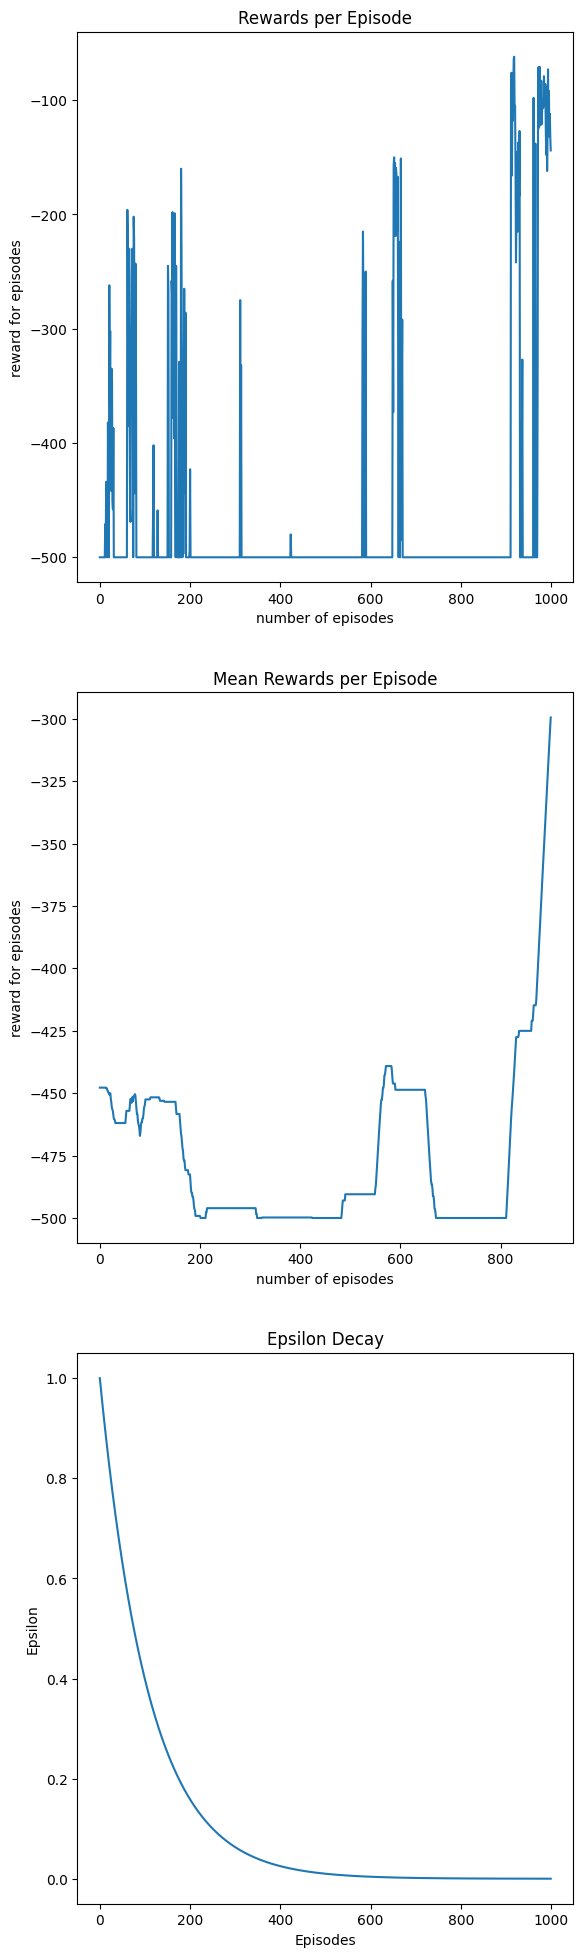

In [ ]:
policy_to_follow = training_gym_env(action_space=3,
                                        obs_space=6,
                                        min_epsilon=0.0001,
                                        max_epsilon=1,
                                        decay_rate=0.001,
                                        num_of_episodes=1000,
                                        gamma=0.93,
                                        batch_size=128,
                                        env=acrobot_env,
                                        replay_buffer_size=1000000,
                                        neurons=[256, 512, 128],
                                        use_duelling=True,
                                        learning_r=0.0001)
acrobot_env.close()

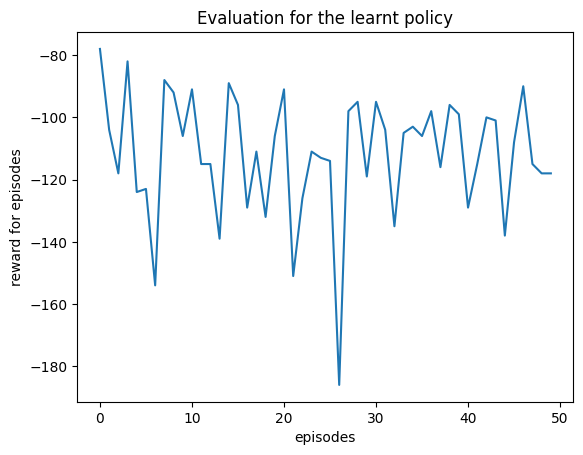

In [ ]:
testing_gym_env(no_evaluation_episodes=50, 
                    policy_to_follow=policy_to_follow, 
                    env=acrobot_env,
                    use_duelling=True)
acrobot_env.close()

## Plotting reward dynamics for both algorithms on same graph for different environments

Text(0.5, 1.0, 'Reward per episode (Grid Environment)')

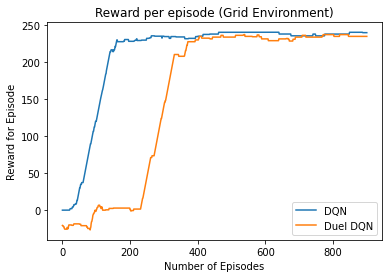

In [ ]:
plt.plot(plot_dict['dqn_grid'][0],label="DQN")
plt.plot(plot_dict['duel_dqn_grid'][0],label="Duel DQN")
plt.legend()
plt.xlabel("Number of Episodes")
plt.ylabel("Reward for Episode")
plt.title("Reward per episode (Grid Environment)")

Text(0.5, 1.0, 'Reward per episode (CartPole-v1 Environment)')

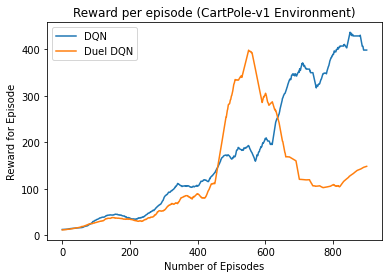

In [ ]:
plt.plot(plot_dict['dqn_CartPole-v1'][0],label="DQN")
plt.plot(plot_dict['duel_dqn_CartPole-v1'][0],label="Duel DQN")
plt.legend()
plt.xlabel("Number of Episodes")
plt.ylabel("Reward for Episode")
plt.title("Reward per episode (CartPole-v1 Environment)")

Text(0.5, 1.0, 'Reward per episode (Acrobot-v1 Environment)')

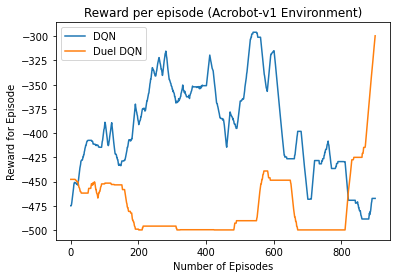

In [ ]:
plt.plot(plot_dict['dqn_Acrobot-v1'][0],label="DQN")
plt.plot(plot_dict['duel_dqn_Acrobot-v1'][0],label="Duel DQN")
plt.legend()
plt.xlabel("Number of Episodes")
plt.ylabel("Reward for Episode")
plt.title("Reward per episode (Acrobot-v1 Environment)")

Text(0.5, 1.0, 'Evaluation of learnt policy (Grid Environment)')

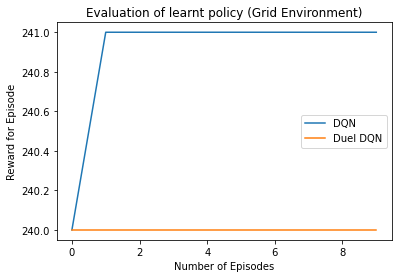

In [ ]:
plt.plot(plot_dict['dqn_test_grid'],label="DQN")
plt.plot(plot_dict['duel_dqn_test_grid'],label="Duel DQN")
plt.legend()
plt.xlabel("Number of Episodes")
plt.ylabel("Reward for Episode")
plt.title("Evaluation of learnt policy (Grid Environment)")

Text(0.5, 1.0, 'Evaluation of learnt policy (CartPole-v1 Environment)')

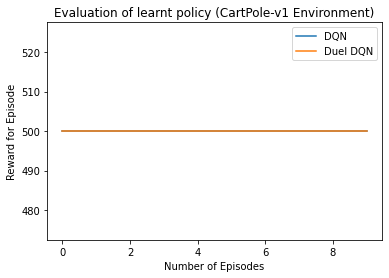

In [ ]:
plt.plot(plot_dict['dqn_test_CartPole-v1'],label="DQN")
plt.plot(plot_dict['duel_dqn_test_CartPole-v1'],label="Duel DQN")
plt.legend()
plt.xlabel("Number of Episodes")
plt.ylabel("Reward for Episode")
plt.title("Evaluation of learnt policy (CartPole-v1 Environment)")

Text(0.5, 1.0, 'Evaluation of learnt policy (Acrobot-v1 Environment)')

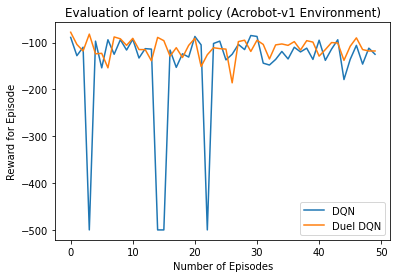

In [ ]:
plt.plot(plot_dict['dqn_test_Acrobot-v1'],label="DQN")
plt.plot(plot_dict['duel_dqn_test_Acrobot-v1'],label="Duel DQN")
plt.legend()
plt.xlabel("Number of Episodes")
plt.ylabel("Reward for Episode")
plt.title("Evaluation of learnt policy (Acrobot-v1 Environment)")